In [1]:
import numpy as np
import pandas as pd
import upsetplot
from upsetplot import from_memberships
from upsetplot import plot
import matplotlib.pyplot as plt
import seaborn as sns

import os,sys
import random

In [2]:
import matplotlib.font_manager
matplotlib.get_cachedir()
matplotlib.rcParams['font.family'] = ['arial']

In [3]:
# Suppress the warning
pd.options.mode.chained_assignment = None  # Default is 'warn'

# Re-enable the warning (optional)
#pd.options.mode.chained_assignment = 'warn'

In [41]:
species_list = ['dmel', 'dsim', 'dana', 'dvir', 'sleb']

groups = pd.read_csv('groups_g.txt', sep=':', header=None, names=['cluster', 'group'])

# extract the species each group has
#groups['species'] = groups['group'].apply(lambda x: ', '.join(set(pd.Series(x.split()).str.extract(r'(\w+)\|')[0].dropna())) if x else None)
groups['species'] = groups['group'].apply(lambda x: ', '.join(dict.fromkeys(pd.Series(x.split()).str.extract(r'(\w+)\|')[0].dropna())) if x else None)

for sp in species_list:
    col_name = sp + '_count'
    groups[col_name] = groups['group'].apply(lambda x: x.count(sp))

In [5]:
species_counts = groups['species'].value_counts()
species_dict = {tuple(k.split(', ')): v for k, v in species_counts.items()}

In [7]:
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

npg_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF"]
sns.set_palette(npg_palette)

npg_palette2 = ["#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF", "#4DBBD599"]

sns.set_style('white', {'axes.linewidth': 0.85})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [42]:
gene_shared_all = groups[groups['species']=='dmel, dsim, dana, dvir, sleb']

In [44]:
gene_single_copy = groups[groups.iloc[:, -5:].isin([0,1]).all(axis=1)]

for species in ['dmel', 'dsim', 'dana', 'dvir', 'sleb']:
    gene_single_copy[f'{species}_gene'] = (
        gene_single_copy['group']
        .str.findall(fr'{species}\|(\S+)')  # Find all gene matches for the species
        .apply(lambda x: ','.join(x) if x else None)  # Convert list to comma-separated string
    )

In [13]:
# Load expression data for each species
dmel_ex = pd.read_csv('ef_TPM/Dmel_comb_TPM.txt', sep='\t', header=0)
dsim_ex = pd.read_csv('ef_TPM/Dsim_comb_TPM.txt', sep='\t', header=0)
dana_ex = pd.read_csv('ef_TPM/Dana_comb_TPM.txt', sep='\t', header=0)
dvir_ex = pd.read_csv('ef_TPM/Dvir_comb_TPM.txt', sep='\t', header=0)
sleb_ex = pd.read_csv('ef_TPM/Sleb_comb_TPM.txt', sep='\t', header=0)

for df in [dmel_ex, dsim_ex, dana_ex, dvir_ex, sleb_ex]:
    df['bac_mean'] = df.iloc[:, -3:].mean(axis=1)
    
for species in ['dsim', 'dana', 'dvir', 'sleb']:
    # Apply string replacement to remove 'gene-' prefix
    globals()[f'{species}_ex']['Gene ID'] = globals()[f'{species}_ex']['Gene ID'].str.replace(r'gene-', '', regex=True)

dmel_res = pd.read_csv('ef_result_v2/dmel_res_table_ef_tb.txt', sep=' ', header=0)
dsim_res = pd.read_csv('ef_result_v2/dsim_res_table_ef_tb.txt', sep=' ', header=0)
dana_res = pd.read_csv('ef_result_v2/dana_res_table_ef_tb.txt', sep=' ', header=0)
dvir_res = pd.read_csv('ef_result_v2/dvir_res_table_ef_tb.txt', sep=' ', header=0)
sleb_res = pd.read_csv('ef_result_v2/sleb_res_table_ef_tb.txt', sep=' ', header=0)

for species in ['dsim', 'dana', 'dvir', 'sleb']:
    # Apply string replacement to remove 'gene-' prefix
    globals()[f'{species}_res']['gene'] = globals()[f'{species}_res']['gene'].str.replace(r'gene-', '', regex=True)

In [46]:
for species, exp_df, res_df in zip(species_list, 
                                  [dmel_ex, dsim_ex, dana_ex, dvir_ex, sleb_ex], 
                                  [dmel_res, dsim_res, dana_res, dvir_res, sleb_res]):
    exp_df = exp_df.drop_duplicates(subset=['Gene ID'])
    res_df = res_df.drop_duplicates(subset=['gene'])
    # Merge expression data (bac_mean)
    gene_single_copy = gene_single_copy.merge(
        exp_df[['Gene ID', 'bac_mean']], 
        left_on=f'{species}_gene', 
        right_on='Gene ID', 
        how='left'
    ).rename(columns={'bac_mean': species}).drop(columns=['Gene ID'])

    # Merge log2FoldChange data and rename it
    gene_single_copy = res_df[['gene', 'log2FoldChange', 'gene_category']].merge(
        gene_single_copy, 
        left_on='gene', 
        right_on=f'{species}_gene', 
        how='right'
    ).rename(columns={'log2FoldChange': f'{species}_fold', 'gene_category': f'{species}_cat'}).drop(columns=['gene'])

In [48]:
conserved = gene_single_copy[gene_single_copy['species']=='dmel, dsim, dana, dvir, sleb']
nonconserved = gene_single_copy[~(gene_single_copy['species']=='dmel, dsim, dana, dvir, sleb')]

conserved['any_sig'] = conserved[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].eq('Upregulated').any(axis=1)
conserved['avg_fold'] = conserved[['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold']].mean(axis=1)
conserved['avg_tpm'] = conserved[['dmel', 'dsim', 'dana', 'dvir', 'sleb']].mean(axis=1)

nonconserved['any_sig'] = nonconserved[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].eq('Upregulated').any(axis=1)
nonconserved['avg_fold'] = nonconserved[['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold']].mean(axis=1)
nonconserved['avg_tpm'] = nonconserved[['dmel', 'dsim', 'dana', 'dvir', 'sleb']].mean(axis=1)

conserved_sig = conserved[conserved['any_sig']].copy()
nonconserved_sig = nonconserved[nonconserved['any_sig']].copy()

conserved_sig['num_sig'] = conserved_sig[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].eq('Upregulated').sum(axis=1)
conserved_sig['ratio_sig'] = conserved_sig['num_sig'] / 5
nonconserved_sig['num_sig'] = nonconserved_sig[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].eq('Upregulated').sum(axis=1)
nonconserved_sig['num_species'] = nonconserved_sig[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].notna().sum(axis=1)
nonconserved_sig['ratio_sig'] = nonconserved_sig['num_sig'] / nonconserved_sig['num_species']

conserved_sig_ct = conserved_sig.shape[0]
conserved_halfsig_ct = conserved_sig[conserved_sig['ratio_sig']>=0.5].shape[0]
conserved_total_ct = conserved.shape[0]

nonconserved_sig_ct = nonconserved_sig.shape[0]
nonconserved_halfsig_ct = nonconserved_sig[nonconserved_sig['ratio_sig']>=0.5].shape[0]
nonconserved_total_ct = nonconserved.shape[0]

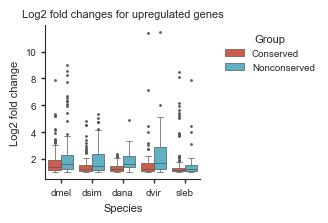

In [26]:
# compare the fold changes for upregulated genes between conserved and nonconserved groups for each species
data = []
for species in species_list:
    conserved_up = conserved[(conserved[f'{species}_cat'] == 'Upregulated')][f'{species}_fold']
    nonconserved_up = nonconserved[(nonconserved[f'{species}_cat'] == 'Upregulated')][f'{species}_fold']
    
    for fold_change in conserved_up:
        data.append({'Species': species, 'Group': 'Conserved', 'Fold Change': fold_change})
    
    for fold_change in nonconserved_up:
        data.append({'Species': species, 'Group': 'Nonconserved', 'Fold Change': fold_change})

data_df = pd.DataFrame(data)

plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=data_df, x='Species', y='Fold Change', hue='Group', linewidth=0.5, flierprops={'markersize': 1})

plt.xlabel('Species', size=8)
plt.ylabel('Log2 fold change', size=8)
plt.title('Log2 fold changes for upregulated genes', size=8)
plt.legend(title='Group')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
                frameon=False)

sns.despine()
#plt.tight_layout()
#plt.show()

plt.savefig("fold_up_genes_con_vs_noncon.svg", dpi=300)

In [30]:
#simulated annealing to select genes with similar expressions
def simulated_annealing(species):
    
    ## Simulated Annealing Parameters ##
    nsteps = 100
    max_iter = 2000
    num = len(dmel_noncons_up)
    print(num)
    K = 0.95 # after each iteration, temperature cools down
    T0 = 100. # initial temprature
    bins = np.arange(0,16.5,.5)
    l1norm_min_list = []
    l1norm_max_list = []

    non_con_gene_df = nonconserved[(nonconserved[f'{species}_cat'] == 'Upregulated')]
    con_gene_df = conserved[(conserved[f'{species}_cat'] == 'Upregulated')]
    print(f"noncons:{non_con_gene_df.shape[0]}\ncons:{con_gene_df.shape[0]}")
    
    non_con_gene_list = non_con_gene_df[f'{species}_gene'].tolist()
    con_gene_list = con_gene_df[f'{species}_gene'].tolist()
    
    for n in range(nsteps):
        list_dng = random.choices(non_con_gene_list,k=num)
        list_rng = random.choices(con_gene_list,k=num)
        list_rng0 = [g for g in list_rng]
        #dng_arr = [fbgn2exp[fbid] for fbid in list_dng]
        #rng_arr = [fbgn2exp[fbid] for fbid in list_rng]
        dng_arr = [non_con_gene_df[non_con_gene_df[f'{species}_gene'] == fbid][species].values[0] for fbid in list_dng]
        rng_arr = [con_gene_df[con_gene_df[f'{species}_gene'] == fbid][species].values[0] for fbid in list_rng]
        dng_hist,edges = np.histogram(dng_arr, bins=bins, range=None, density=True, weights=None)
        rng_hist,edges = np.histogram(rng_arr, bins=bins, range=None, density=True, weights=None)
        l1norm0 = sum(abs(rng_hist-dng_hist))
        l1norm_min = 1e9
        min_iter = 0
        list_min = []
        rng_hist_min = []
    
        if n==0:
            hist2plot_dng  = [d for d in dng_hist] # random permutated de novo genes
            hist2plot_rng0 = [d for d in rng_hist] # not expression matched non-de novo genes
        
        print(f"step {n}","iter 0",l1norm0)
        existed = {g:1 for g in list_rng}
        l1norm_max_list.append(l1norm0)
    
        # Actual Simulated Annealing #
        T = T0
        for it in range(max_iter):
            # decide which one to mutate #
            to_mut = random.randint(0,num-1)
            old_gene = list_rng[to_mut]
            gene_pool = [g for g in con_gene_df[f'{species}_gene']]# if g not in existed]
            #print(it, len(gene_pool))
            mut_gene = random.choice(gene_pool)
            
            ## mutate ##
            list_rng[to_mut] = mut_gene
            #existed[mut_gene] = 1
            #rng_arr = [fbgn2exp[fbid] for fbid in list_rng]
            #print(list_rng)
            
            rng_arr = [con_gene_df[con_gene_df[f'{species}_gene'] == fbid][species].values[0] for fbid in list_rng]
            rng_hist,edges = np.histogram(rng_arr, bins=bins, range=None, density=True, weights=None)
            l1norm1 = sum(abs(rng_hist-dng_hist))
            
            ## accept if l1norm decrease ##
            paccpt = 1.0 if l1norm1<l1norm0 else np.exp(-(l1norm1-l1norm0)/T)
            p = random.uniform(0,1)
            if p < paccpt:
                l1norm0 = l1norm1
                if l1norm0 < l1norm_min:
                    l1norm_min = l1norm0
                    list_min = [g for g in list_rng]
                    rng_hist_min = [d for d in rng_hist]
                    min_iter = it
            else:
                ## reject change
                list_rng[to_mut] = old_gene
    
            T = T*K
    
        if n==0:
            hist2plot_rng1 = [d for d in rng_hist_min]
    
        print(f"step {n}",f"iter {min_iter}",l1norm_min)
        l1norm_min_list.append(l1norm_min)
    
        np.savetxt(f"genes_with_similar_expression_{species}/genes_randomly_selected_%d.txt"%(n+1),list_rng,fmt="%s")
        np.savetxt(f"genes_with_similar_expression_{species}/genes_randomly_selected_init_%d.txt"%(n+1),list_rng0,fmt="%s")
        np.savetxt(f"genes_with_similar_expression_{species}/denovo_genes_randomly_selected_%d.txt"%(n+1),list_dng,fmt="%s")

<Axes: >

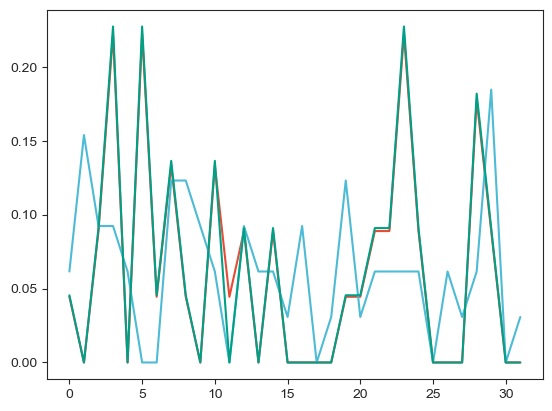

In [314]:
sns.lineplot(hist2plot_dng)
sns.lineplot(hist2plot_rng0)
sns.lineplot(hist2plot_rng1)

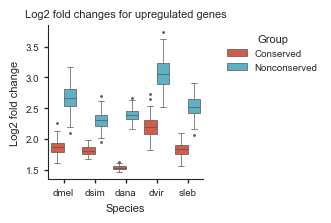

In [54]:
# compare the fold changes for upregulated genes between conserved and nonconserved groups for each species
# by randomly selecting some genes using Junhui's script
data = []



for species in species_list:
    conserved_up = conserved[(conserved[f'{species}_cat'] == 'Upregulated')]#[f'{species}_fold']
    nonconserved_up = nonconserved[(nonconserved[f'{species}_cat'] == 'Upregulated')]#[f'{species}_fold']
    for i in range(1,101):
        genes_sample = pd.read_csv(f'genes_with_similar_expression_{species}/genes_randomly_selected_{i}.txt', header=None)
        genes_denovo_sample = pd.read_csv(f'genes_with_similar_expression_{species}/denovo_genes_randomly_selected_{i}.txt', header=None)
    
        conserved_up_sample = conserved_up.merge(genes_sample, left_on=f'{species}_gene', right_on=0, how='right')[f'{species}_fold']
        nonconserved_up_sample = nonconserved_up.merge(genes_denovo_sample, left_on=f'{species}_gene', right_on=0, how='right')[f'{species}_fold']
        data.append({
                'Species': species,
                'Group': 'Conserved',
                'Mean Fold Change': conserved_up_sample.mean()
            })
        data.append({
            'Species': species,
            'Group': 'Nonconserved',
            'Mean Fold Change': nonconserved_up_sample.mean()
        })
    
            
            # for fold_change in conserved_up_sample:
            #     data.append({'Species': species, 'Group': 'Conserved', 'Fold Change': fold_change})
            
            # for fold_change in nonconserved_up_sample:
            #     data.append({'Species': species, 'Group': 'Nonconserved', 'Fold Change': fold_change})
    
data_df = pd.DataFrame(data)

plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=data_df, x='Species', y='Mean Fold Change', hue='Group', linewidth=0.5, flierprops={'markersize': 1})

plt.xlabel('Species', size=8)
plt.ylabel('Log2 fold change', size=8)
plt.title('Log2 fold changes for upregulated genes', size=8)
plt.legend(title='Group')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
                frameon=False)

sns.despine()
#plt.tight_layout()
#plt.show()

#plt.savefig("fold_up_genes_con_vs_noncon_annealed.svg", dpi=300)

In [ ]:
from scipy.stats import levene
from scipy.stats import ttest_ind

In [66]:
for species in species_list:
    con = data_df[(data_df['Species'] == species) & (data_df['Group'] == 'Conserved')]['Mean Fold Change']
    noncon = data_df[(data_df['Species'] == species) & (data_df['Group'] == 'Nonconserved')]['Mean Fold Change']
    stat, p_value = levene(con, noncon)
    print(f"Levene test p-value for {species} (con vs noncon): {p_value}")
    t_stat_con, p_val_con = ttest_ind(con, noncon, equal_var=False)
    print(f"T-test stats ({species}): t-stat = {t_stat_con}, p-value = {p_val_con}")

Levene test p-value for dmel (con vs noncon): 2.4393000702363345e-08
T-test stats (dmel): t-stat = -32.908032901520805, p-value = 1.8335916036806663e-71
Levene test p-value for dsim (con vs noncon): 8.224605951291955e-06
T-test stats (dsim): t-stat = -31.456290429855525, p-value = 2.5532848729079305e-68
Levene test p-value for dana (con vs noncon): 3.295003403912739e-13
T-test stats (dana): t-stat = -84.70053646383231, p-value = 2.313793044701479e-112
Levene test p-value for dvir (con vs noncon): 0.009023551084059988
T-test stats (dvir): t-stat = -29.68493062130208, p-value = 1.9914694452846962e-72
Levene test p-value for sleb (con vs noncon): 0.005583084883997542
T-test stats (sleb): t-stat = -36.20586650418137, p-value = 6.71707150963919e-85


<Axes: xlabel='Group', ylabel='Count'>

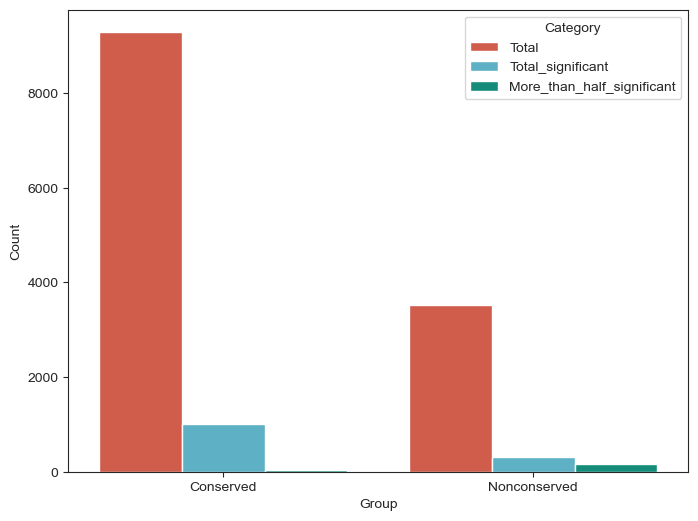

In [129]:
# bar plot
data = []

conserved_sig_ct = conserved_sig.shape[0]
conserved_halfsig_ct = conserved_sig[conserved_sig['ratio_sig']>=0.5].shape[0]
conserved_total_ct = conserved.shape[0]
conserved_sig_ratio = conserved_sig_ct / conserved_total_ct
conserved_halfsig_ratio = conserved_halfsig_ct / conserved_sig_ct

nonconserved_sig_ct = nonconserved_sig.shape[0]
nonconserved_halfsig_ct = nonconserved_sig[nonconserved_sig['ratio_sig']>=0.5].shape[0]
nonconserved_total_ct = nonconserved.shape[0]
nonconserved_sig_ratio = nonconserved_sig_ct / nonconserved_total_ct
nonconserved_halfsig_ratio = nonconserved_halfsig_ct / nonconserved_sig_ct

data = {
    'Group': ['Conserved', 'Conserved', 'Conserved', 'Nonconserved', 'Nonconserved', 'Nonconserved'],
    'Category': ['Total', 'Total_significant', 'More_than_half_significant', 'Total', 'Total_significant', 'More_than_half_significant'],
    'Count': [conserved_total_ct, conserved_sig_ct, conserved_halfsig_ct, nonconserved_total_ct, nonconserved_sig_ct, nonconserved_halfsig_ct]
}

data_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.barplot(data=data_df, x='Group', y='Count', hue='Category')

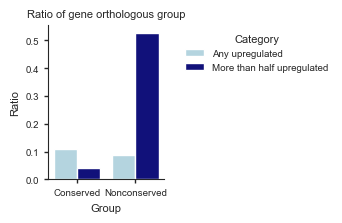

In [130]:
# bar plot
data = []

conserved_sig_ct = conserved_sig.shape[0]
conserved_halfsig_ct = conserved_sig[conserved_sig['ratio_sig']>=0.5].shape[0]
conserved_total_ct = conserved.shape[0]
conserved_sig_ratio = conserved_sig_ct / conserved_total_ct
conserved_halfsig_ratio = conserved_halfsig_ct / conserved_sig_ct

nonconserved_sig_ct = nonconserved_sig.shape[0]
nonconserved_halfsig_ct = nonconserved_sig[nonconserved_sig['ratio_sig']>=0.5].shape[0]
nonconserved_total_ct = nonconserved.shape[0]
nonconserved_sig_ratio = nonconserved_sig_ct / nonconserved_total_ct
nonconserved_halfsig_ratio = nonconserved_halfsig_ct / nonconserved_sig_ct

data = {
    'Group': ['Conserved', 'Conserved', 'Nonconserved', 'Nonconserved'],
    'Category': ['Any upregulated', 'More than half upregulated', 'Any upregulated', 'More than half upregulated'],
    'Ratio': [conserved_sig_ratio, conserved_halfsig_ratio, nonconserved_sig_ratio, nonconserved_halfsig_ratio]}

data_df = pd.DataFrame(data)

plt.figure(figsize=(1.5, 2))
ax = sns.barplot(data=data_df, x='Group', y='Ratio', hue='Category', palette=['lightblue', 'darkblue'])

plt.xlabel('Group', size=8)
plt.ylabel('Ratio', size=8)
plt.title('Ratio of gene orthologous group', size=8)

ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
plt.legend(title='Category')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, 
               frameon=False)
sns.despine()
#plt.tight_layout()
#plt.show()
#plt.savefig("ratio_genes_con_vs_noncon.svg", dpi=300)

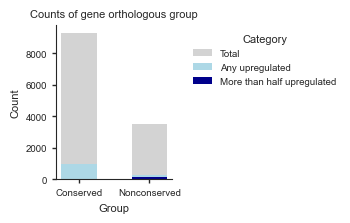

In [132]:
# stacked bar plot
stacked_data = {
    'Group': ['Conserved', 'Nonconserved'],
    'Total': [conserved_total_ct, nonconserved_total_ct],
    'Significant': [conserved_sig_ct, nonconserved_sig_ct],
    'More_than_half_significant': [conserved_halfsig_ct, nonconserved_halfsig_ct]
}

stacked_df = pd.DataFrame(stacked_data)

plt.figure(figsize=(1.5, 2))

bar_width = 0.5

ax = plt.bar(stacked_df['Group'], stacked_df['Total'], label='Total', width=bar_width, color='lightgrey', linewidth=0)
ax = plt.bar(stacked_df['Group'], stacked_df['Significant'], label='Any upregulated', width=bar_width, color='lightblue',
             linewidth=0)
ax = plt.bar(stacked_df['Group'], stacked_df['More_than_half_significant'], label='More than half upregulated', width=bar_width,
             linewidth=0, color='darkblue')

plt.xlabel('Group', size=8)
plt.ylabel('Count', size=8)
plt.title('Counts of gene orthologous group', size=8)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
#ax.tick_params(axis='x', which='both', direction='out', length=3, width=1, labelsize=7, labelrotation=45)
plt.legend(title='Category')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, 
               frameon=False)
sns.despine()
#plt.tight_layout()
#plt.show()
#plt.savefig("count_stacked_genes_con_vs_noncon.svg", dpi=300)


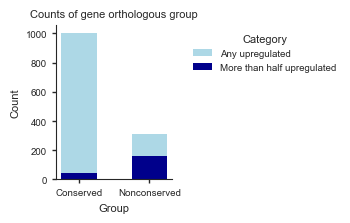

In [149]:
# stacked bar plot without Total
stacked_data = {
    'Group': ['Conserved', 'Nonconserved'],
    'Total': [conserved_total_ct, nonconserved_total_ct],
    'Significant': [conserved_sig_ct, nonconserved_sig_ct],
    'More_than_half_significant': [conserved_halfsig_ct, nonconserved_halfsig_ct]
}

stacked_df = pd.DataFrame(stacked_data)

plt.figure(figsize=(1.5, 2))

bar_width = 0.5

ax = plt.bar(stacked_df['Group'], stacked_df['Significant'], label='Any upregulated', width=bar_width, color='lightblue',
             linewidth=0)
ax = plt.bar(stacked_df['Group'], stacked_df['More_than_half_significant'], label='More than half upregulated', width=bar_width,
             linewidth=0, color='darkblue')

plt.xlabel('Group', size=8)
plt.ylabel('Count', size=8)
plt.title('Counts of gene orthologous group', size=8)

ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
#ax.tick_params(axis='x', which='both', direction='out', length=3, width=1, labelsize=7, labelrotation=45)
plt.legend(title='Category')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, 
               frameon=False)
sns.despine()
#plt.tight_layout()
#plt.show()
plt.savefig("count_stacked_genes_con_vs_noncon_wo_total_0425.svg", dpi=300)

In [171]:
from scipy.stats import fisher_exact

# ---- Fisher's Exact Test for 'Significant' ----
sig_table = [
    [conserved_sig_ct, conserved_total_ct - conserved_sig_ct],
    [nonconserved_sig_ct, nonconserved_total_ct - nonconserved_sig_ct]
]

odds_sig, p_sig = fisher_exact(sig_table)
print(f"Fisher's Exact Test (Significant): p-value = {p_sig:.4g}")

# ---- Fisher's Exact Test for 'More_than_half_significant' ----
half_sig_table = [
    [conserved_halfsig_ct, conserved_sig_ct - conserved_halfsig_ct],
    [nonconserved_halfsig_ct, nonconserved_sig_ct - nonconserved_halfsig_ct]
]

odds_half_sig, p_half_sig = fisher_exact(half_sig_table)
print(f"Fisher's Exact Test (More than half significant): p-value = {p_half_sig:.4g}")


Fisher's Exact Test (Significant): p-value = 0.0007683
Fisher's Exact Test (More than half significant): p-value = 1.252e-79


In [172]:
# Proportions for each group
conserved_sig_prop = conserved_sig_ct / conserved_total_ct
nonconserved_sig_prop = nonconserved_sig_ct / nonconserved_total_ct

conserved_half_sig_prop = conserved_halfsig_ct / conserved_sig_ct
nonconserved_half_sig_prop = nonconserved_halfsig_ct / nonconserved_sig_ct

# Print mean proportions
print(f"Mean proportion of Significant (Conserved): {conserved_sig_prop:.3f}")
print(f"Mean proportion of Significant (Nonconserved): {nonconserved_sig_prop:.3f}")

print(f"Mean proportion of More than half Significant (Conserved): {conserved_half_sig_prop:.3f}")
print(f"Mean proportion of More than half Significant (Nonconserved): {nonconserved_half_sig_prop:.3f}")


Mean proportion of Significant (Conserved): 0.108
Mean proportion of Significant (Nonconserved): 0.088
Mean proportion of More than half Significant (Conserved): 0.043
Mean proportion of More than half Significant (Nonconserved): 0.528


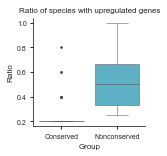

In [422]:
# compare the ratio of species in each orthologous group with upregulated genes between conserved and nonconserved groups
data = []
conserved_sig_ratio = conserved_sig['ratio_sig']
nonconserved_sig_ratio = nonconserved_sig['ratio_sig']
    
for ratio in conserved_sig_ratio:
    data.append({'Group': 'Conserved', 'Ratio': ratio})

for ratio in nonconserved_sig_ratio:
    data.append({'Group': 'Nonconserved', 'Ratio': ratio})

data_df = pd.DataFrame(data)

plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=data_df, x='Group', y='Ratio', linewidth=0.5, flierprops={'markersize': 1})

plt.xlabel('Group', size=8)
plt.ylabel('Ratio', size=8)
plt.title('Ratio of species with upregulated genes', size=8)
#plt.legend(title='Group')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
#                frameon=False)

sns.despine()
#plt.tight_layout()
#plt.show()

plt.savefig("ratio_species_up_genes_con_vs_noncon.svg", dpi=300)

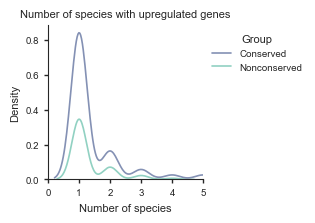

In [49]:
# compare the number of species in each orthologous group with upregulated genes between conserved and nonconserved groups, not ratios

conserved_sig['type'] = 'Conserved'
nonconserved_sig['type'] = 'Nonconserved'
combined_df = pd.concat([conserved_sig, nonconserved_sig], ignore_index=True)

plt.figure(figsize=(2, 2))

ax = sns.kdeplot(data=combined_df, x='num_sig', hue='type', lw=1.2, palette=npg_palette2[:2])

plt.xlabel('Number of species', size=8)
plt.ylabel('Density', size=8)
plt.title('Number of species with upregulated genes', size=8)
#plt.legend(title='Group')
plt.xlim(0,5)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
                frameon=False)

sns.despine()
#plt.tight_layout()
#plt.show()

#plt.savefig("density_species_up_genes_con_vs_noncon.svg", dpi=300, bbox_inches='tight')

# begin analysis on de novo genes using de novo gene's list

In [ ]:
denovo = pd.read_csv("denovo_list.csv")

denovo = denovo.loc[:,['FBID', 'seqlen', 'lineage_age', 'signalp']]

In [20]:
conserved_denovo = denovo.merge(conserved, left_on='FBID', right_on='dmel_gene', how='inner')

/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_27532/3109307433.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conserved_br.index, y=conserved_br.values, palette='Set2')


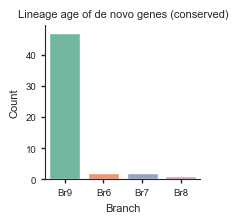

In [70]:
conserved_br = conserved_denovo['lineage_age'].value_counts()

plt.figure(figsize=(2, 2))
ax = sns.barplot(x=conserved_br.index, y=conserved_br.values, palette='Set2')

plt.xlabel('Branch', size=8)
plt.ylabel('Count', size=8)
plt.title('Lineage age of de novo genes (conserved)', size=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.despine()
plt.savefig("lineage_denovo_genes_con.svg", dpi=300)

In [71]:
nonconserved_denovo = denovo.merge(nonconserved, left_on='FBID', right_on='dmel_gene', how='inner')

In [72]:
merged = denovo.merge(nonconserved, left_on='FBID', right_on='dmel_gene', how='outer', indicator=True)
nonconserved_nondenovo = merged[merged['_merge'] == 'right_only']

/var/folders/jt/wf6lflrs1_94wjjrq_r5mrvm0000gn/T/ipykernel_27532/550858797.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=nonconserved_br.index, y=nonconserved_br.values, palette='Set2')


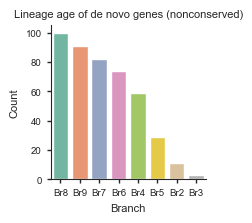

In [73]:
nonconserved_br = nonconserved_denovo['lineage_age'].value_counts()

plt.figure(figsize=(2, 2))
ax = sns.barplot(x=nonconserved_br.index, y=nonconserved_br.values, palette='Set2')

plt.xlabel('Branch', size=8)
plt.ylabel('Count', size=8)
plt.title('Lineage age of de novo genes (nonconserved)', size=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.despine()
#plt.savefig("lineage_denovo_genes_noncon.svg", dpi=300)

In [75]:
conserved_sig

,sleb_fold,sleb_cat,dvir_fold,dvir_cat,dana_fold,dana_cat,dsim_fold,dsim_cat,dmel_fold,dmel_cat,...,dmel,dsim,dana,dvir,sleb,any_sig,avg_fold,avg_tpm,num_sig,ratio_sig
78,-0.632093,Non-significant,-0.312814,Non-significant,1.006807,Upregulated,0.701905,Non-significant,0.170158,Non-significant,...,8.326394,13.815801,11.745480,30.114073,6.215263,True,0.186793,14.043402,1,0.2
106,1.010949,Upregulated,-0.171155,Non-significant,-0.135978,Non-significant,-0.273681,Non-significant,-0.404771,Non-significant,...,28.133374,46.816006,34.821150,59.802955,56.361179,True,0.005073,45.186933,1,0.2
113,1.014465,Upregulated,-0.312604,Non-significant,0.296082,Non-significant,0.171477,Non-significant,-0.022697,Non-significant,...,2.688630,2.097324,2.192075,15.991742,8.782454,True,0.229344,6.350445,1,0.2
166,1.013053,Upregulated,-0.094456,Non-significant,-0.047254,Non-significant,-0.306268,Non-significant,-0.499930,Non-significant,...,53.108637,72.656314,30.527838,31.121024,53.829178,True,0.013029,48.248598,1,0.2
181,-0.064270,Non-significant,-0.055831,Non-significant,1.047384,Upregulated,0.440790,Non-significant,0.373553,Non-significant,...,4.640628,10.816027,6.533810,2.943420,3.689999,True,0.348326,5.724777,1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9664,-0.476548,Non-significant,0.193034,Non-significant,1.466478,Upregulated,-0.418245,Non-significant,0.492652,Non-significant,...,48.280795,27.302379,21.452203,9.108894,6.887594,True,0.251474,22.606373,1,0.2
9715,1.000157,Upregulated,-0.208942,Non-significant,-0.234166,Non-significant,-0.366444,Non-significant,-0.504853,Non-significant,...,27.635214,41.662623,49.486988,56.171438,33.460689,True,-0.062850,41.683390,1,0.2
9742,0.189048,Non-significant,0.001421,Non-significant,0.171228,Non-significant,0.133414,Non-significant,1.121704,Upregulated,...,0.177583,1.351783,0.073382,0.134950,0.079201,True,0.323363,0.363380,1,0.2
9835,-0.326657,Non-significant,0.359270,Non-significant,1.042800,Upregulated,0.305275,Non-significant,0.425075,Non-significant,...,85.261861,38.967909,62.912674,54.578705,33.999104,True,0.361153,55.144051,1,0.2


In [ ]:
combined_sig = pd.concat([conserved_sig, nonconserved_sig], axis=0)  # Stack rows
combined_sig_denovo = denovo.merge(combined_sig, left_on='FBID', right_on='dmel_gene', how='inner')

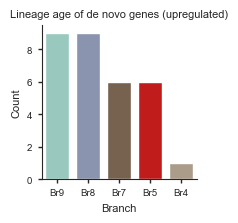

In [102]:
# plot all upregulated
combined_sig_denovo_br = combined_sig_denovo['lineage_age'].value_counts()
order = combined_sig_denovo_br.index.sort_values(ascending=False)

plt.figure(figsize=(2, 2))
ax = sns.barplot(x=combined_sig_denovo_br.index, y=combined_sig_denovo_br.values, hue=combined_sig_denovo_br.index, 
                 palette=npg_palette2[:5], legend=False, order=order)

plt.xlabel('Branch', size=8)
plt.ylabel('Count', size=8)
plt.title('Lineage age of de novo genes (upregulated)', size=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.despine()
plt.savefig("lineage_denovo_genes_upregulated.svg", dpi=300)

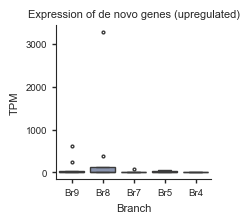

In [109]:
# plot all upregulated
combined_sig_denovo_br = combined_sig_denovo['lineage_age'].value_counts()
order = combined_sig_denovo_br.index.sort_values(ascending=False)

plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=combined_sig_denovo, x='lineage_age', y='dmel', hue='lineage_age', 
                 palette=npg_palette2[:5], legend=False, order=order, fliersize=2)

plt.xlabel('Branch', size=8)
plt.ylabel('TPM', size=8)
plt.title('Expression of de novo genes (upregulated)', size=8)
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)

sns.despine()
plt.savefig("lineage_denovo_genes_upregulated_expression.svg", dpi=300)

In [444]:
gene_single_copy['any_sig'] = gene_single_copy[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].eq('Upregulated').any(axis=1)
gene_single_copy['avg_fold'] = gene_single_copy[['dmel_fold', 'dsim_fold', 'dana_fold', 'dvir_fold', 'sleb_fold']].mean(axis=1)
gene_single_copy['avg_tpm'] = gene_single_copy[['dmel', 'dsim', 'dana', 'dvir', 'sleb']].mean(axis=1)

gene_single_copy_denovo = denovo.merge(gene_single_copy, left_on='FBID', right_on='dmel_gene', how='inner')
merged = denovo.merge(gene_single_copy, left_on='FBID', right_on='dmel_gene', how='outer', indicator=True)
gene_single_copy_nondenovo = merged[merged['_merge'] == 'right_only']

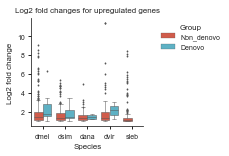

In [442]:
# compare the fold changes for upregulated genes between conserved and nonconserved groups for each species
data = []
for species in species_list:
    conserved_up = gene_single_copy_nondenovo[(gene_single_copy_nondenovo[f'{species}_cat'] == 'Upregulated')][f'{species}_fold']
    nonconserved_up = gene_single_copy_denovo[(gene_single_copy_denovo[f'{species}_cat'] == 'Upregulated')][f'{species}_fold']
    
    for fold_change in conserved_up:
        data.append({'Species': species, 'Group': 'Non_denovo', 'Fold Change': fold_change})
    
    for fold_change in nonconserved_up:
        data.append({'Species': species, 'Group': 'Denovo', 'Fold Change': fold_change})

data_df = pd.DataFrame(data)

plt.figure(figsize=(2, 2))
ax = sns.boxplot(data=data_df, x='Species', y='Fold Change', hue='Group', linewidth=0.5, flierprops={'markersize': 1})

plt.xlabel('Species', size=8)
plt.ylabel('Log2 fold change', size=8)
plt.title('Log2 fold changes for upregulated genes', size=8)
plt.legend(title='Group')
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), title="Group", fontsize=7, title_fontsize=8, markerscale=0.8, 
                frameon=False)

sns.despine()
#plt.tight_layout()
#plt.show()

plt.savefig("fold_up_genes_denovo_vs_nondenovo.svg", dpi=300)

In [447]:
gene_denovo_sig = gene_single_copy_denovo[gene_single_copy_denovo['any_sig']==True]

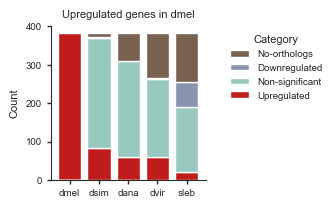

In [174]:
for species in species_list:
    upregulated_dmel[f'{species}_cat'] = upregulated_dmel[f'{species}_cat'].fillna('No-orthologs')

df_long = upregulated_dmel[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].melt(var_name="species", value_name="Category")

df_long['species'] = df_long['species'].str.replace('_cat', '', regex=False)

# Count occurrences of each category per species
df_counts = df_long.value_counts(["species", "Category"]).reset_index(name="Count")

# Pivot the data to create columns for each category
df_pivot = df_counts.pivot_table(index='species', columns='Category', values='Count', fill_value=0)

# Reorder columns based on desired category order (Upregulated, Non-significant, Downregulated)
df_pivot = df_pivot[['Upregulated', 'Non-significant', 'Downregulated', 'No-orthologs']]
# Reorder the rows based on species_order
species_order = species_list
df_pivot = df_pivot.loc[species_order]

# Plot stacked bar chart
reversed_palette = npg_palette2[:3][::-1] + [npg_palette2[3]]
seaborn_palette = sns.color_palette(reversed_palette, n_colors=4, desat=0.75) # default destauration value in seaborn

ax = df_pivot.plot(kind='bar', stacked=True, color=seaborn_palette, width=0.8, alpha=1, figsize=(2, 2))

# Customize the labels and title
#ax.set_ylim(0,140)
ax.set_xlabel("", fontsize=8)
ax.set_ylabel("Count", fontsize=8)
ax.set_title("Upregulated genes in dmel", fontsize=8)

# Adjust tick parameters for both x and y axis
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Reverse the order of the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, frameon=False, loc='upper left', bbox_to_anchor=(1.1, 1))

sns.despine()

#plt.show()
plt.savefig("upregulated_dmel_cat_allspecies.svg", dpi=300)#, bbox_inches='tight')

In [ ]:
upregulated_dsim = gene_single_copy[gene_single_copy['dsim_cat']=='Upregulated']
dsim_no = upregulated_dmel[upregulated_dmel['dsim_cat']=='Non-significant']
dsim_no['dmel_gene'].to_csv('dsim_no.txt', index=False, header=None)

In [51]:
upregulated_dvir = gene_single_copy[gene_single_copy['dvir_cat']=='Upregulated']

In [ ]:
dsim_no = upregulated_dvir[upregulated_dvir['dsim_cat']=='Non-significant']
dsim_no['dmel_gene'].to_csv('dsim_no_indvir.txt', index=False, header=None)
dana_no = upregulated_dvir[upregulated_dvir['dana_cat']=='Non-significant']
dana_no['dmel_gene'].to_csv('dana_no_indvir.txt', index=False, header=None)

In [ ]:
dmel_no = upregulated_dvir[upregulated_dvir['dsim_cat']=='Non-significant']

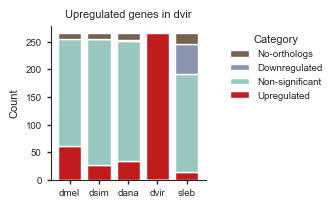

In [52]:
for species in species_list:
    upregulated_dvir[f'{species}_cat'] = upregulated_dvir[f'{species}_cat'].fillna('No-orthologs')
    
df_long = upregulated_dvir[['dmel_cat', 'dsim_cat', 'dana_cat', 'dvir_cat', 'sleb_cat']].melt(var_name="species", value_name="Category")

df_long['species'] = df_long['species'].str.replace('_cat', '', regex=False)

# Count occurrences of each category per species
df_counts = df_long.value_counts(["species", "Category"]).reset_index(name="Count")

# Pivot the data to create columns for each category
df_pivot = df_counts.pivot_table(index='species', columns='Category', values='Count', fill_value=0)

# Reorder columns based on desired category order (Upregulated, Non-significant, Downregulated)
df_pivot = df_pivot[['Upregulated', 'Non-significant', 'Downregulated', 'No-orthologs']]
# Reorder the rows based on species_order
species_order = species_list
df_pivot = df_pivot.loc[species_order]

# Plot stacked bar chart
reversed_palette = npg_palette2[:3][::-1] + [npg_palette2[3]]
seaborn_palette = sns.color_palette(reversed_palette, n_colors=4, desat=0.75) # default destauration value in seaborn

ax = df_pivot.plot(kind='bar', stacked=True, color=seaborn_palette, width=0.8, alpha=1, figsize=(2, 2))

# Customize the labels and title
#ax.set_ylim(0,280)
ax.set_xlabel("", fontsize=8)
ax.set_ylabel("Count", fontsize=8)
ax.set_title("Upregulated genes in dvir", fontsize=8)

# Adjust tick parameters for both x and y axis
ax.tick_params(axis='both', which='both', direction='out', length=3, width=1, labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Reverse the order of the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Category", fontsize=7, title_fontsize=8, markerscale=0.8, frameon=False, loc='upper left', bbox_to_anchor=(1.1, 1))

sns.despine()
#plt.savefig("upregulated_dvir_cat_allspecies_pr.svg", dpi=300)#, bbox_inches='tight')